In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import numpy.linalg as LA
from scipy import integrate

In [2]:
from algorithms.meshforrectangle import MeshForRectangle

In [3]:
w = 1
h = 2
rectangle = [[0,0],[0,h],[w,h],[w,0]]
rectangle_area = h*w

u = lambda x, y: (x - 1)**2 * (y - 2)**2 *x*y
du_dx1 = lambda x, y: (-1 + x) * (-1 + 3*x) * (-2 + y)**2 * y
du_dx2 = lambda x, y: (-1 + x)**2 * x * (-2 + y) * (-2 + 3*y)

a11 = 1
a22 = 1

d = 0

#f = lambda x, y: 3 

f = lambda x, y: 2*(-2+3*x)*(-2+y)**2*y+2*(-1+x)**2*x*(-4+3*y)

beta = 1e-10
sigma = 1e+10
psi = 0

In [4]:
nx = 8
ny = 16
mesher = MeshForRectangle(nx, ny)
triangulation = list(map(lambda t: t.get_points(), mesher.triangulate(rectangle)))

In [5]:
triangulation

[[[0, 0], [0.125, 0.125], [0, 0.125]],
 [[0, 0], [0.125, 0], [0.125, 0.125]],
 [[0, 0.125], [0.125, 0.25], [0, 0.25]],
 [[0, 0.125], [0.125, 0.125], [0.125, 0.25]],
 [[0, 0.25], [0.125, 0.375], [0, 0.375]],
 [[0, 0.25], [0.125, 0.25], [0.125, 0.375]],
 [[0, 0.375], [0.125, 0.5], [0, 0.5]],
 [[0, 0.375], [0.125, 0.375], [0.125, 0.5]],
 [[0, 0.5], [0.125, 0.625], [0, 0.625]],
 [[0, 0.5], [0.125, 0.5], [0.125, 0.625]],
 [[0, 0.625], [0.125, 0.75], [0, 0.75]],
 [[0, 0.625], [0.125, 0.625], [0.125, 0.75]],
 [[0, 0.75], [0.125, 0.875], [0, 0.875]],
 [[0, 0.75], [0.125, 0.75], [0.125, 0.875]],
 [[0, 0.875], [0.125, 1.0], [0, 1.0]],
 [[0, 0.875], [0.125, 0.875], [0.125, 1.0]],
 [[0, 1.0], [0.125, 1.125], [0, 1.125]],
 [[0, 1.0], [0.125, 1.0], [0.125, 1.125]],
 [[0, 1.125], [0.125, 1.25], [0, 1.25]],
 [[0, 1.125], [0.125, 1.125], [0.125, 1.25]],
 [[0, 1.25], [0.125, 1.375], [0, 1.375]],
 [[0, 1.25], [0.125, 1.25], [0.125, 1.375]],
 [[0, 1.375], [0.125, 1.5], [0, 1.5]],
 [[0, 1.375], [0.125, 1.3

In [6]:
points = np.unique(np.concatenate(triangulation), axis=0).tolist()
triangles = list(map(lambda tri: [points.index(tri[0]),
                                  points.index(tri[1]),
                                  points.index(tri[2]),], triangulation))

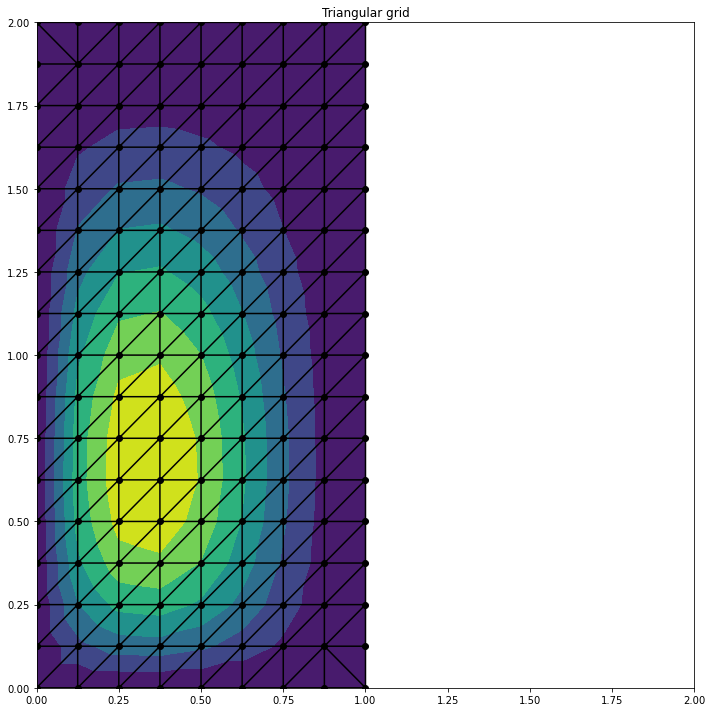

In [7]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
ax.tricontourf(triang, z)
ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')

fig.tight_layout()
plt.savefig('s.pdf')
plt.show()

In [8]:
n =  len(triangles)
triangle_area = rectangle_area / n
s = triangle_area

def K_i(b, c, s, a11, a22):
    K = np.zeros([3, 3])
    for i in range(3):
        for j in range(3):
            K[i][j] = (a11 * (b[i] * b[j]) + a22 * (c[i] * c[j]))

    K = K / (2 * 2 * s)
    return K


def fill_A_with_K_i(A, K, tri):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += K[i][j]  
    
def fill_A_with_M_i(A, M, tri, d):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += d * M[i][j]   
            
def fill_F_with_phi_i(F, tri, points, M):
    Qe = np.zeros(3);
    Me = np.sum(M,axis=1)
    for i in range(3):
        Qe[i] = -Me[i] * f(*points[tri[i]])

    for i in range(3):
        F[tri[i]] += Qe[i]


In [9]:
G = h / ny

Re = (sigma*G)/(6*beta) * np.array([[2, 1], [1, 2]])
Pe = (psi*G)/(2*beta) * np.array([1, 1])
Me = (s)/(12) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

a = np.zeros([n, 3])
b = np.zeros([n, 3])
c = np.zeros([n, 3])
phi = np.zeros([n, 3])

A = np.zeros([len(points), len(points)])
F = np.zeros([len(points), 1])
not_boundary = []

for i, tri in enumerate(triangles):
    
    p1 = points[tri[0]]
    p2 = points[tri[1]] 
    p3 = points[tri[2]]
    
    boundary_points = np.array([])
    if sum(np.array([p1[0], p2[0], p3[0]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == 0]
    elif sum(np.array([p1[0], p2[0], p3[0]]).round(5) == w) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == w]        
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == 0]
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == h) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == h]

    if boundary_points.size:

        boundary_points = boundary_points.tolist()
        if p2 not in boundary_points:
            boundary_points.reverse()

        A[points.index(boundary_points[0])][points.index(boundary_points[0])] += Re[0][0]
        A[points.index(boundary_points[0])][points.index(boundary_points[1])] += Re[0][1]
        A[points.index(boundary_points[1])][points.index(boundary_points[0])] += Re[1][0]
        A[points.index(boundary_points[1])][points.index(boundary_points[1])] += Re[1][1]
        
        F[points.index(boundary_points[0])] += Pe[0]
        F[points.index(boundary_points[1])] += Pe[1]   

    groups = [
        (p2, p3, _), (p3, p1, _), (p1, p2, _)
    ]
    
    for j, group in enumerate(groups):
        t1 = group[0]
        t2 = group[1]
        
        b[i][j] = t2[1] - t1[1]
        c[i][j] = t2[0] - t1[0]
        
    K = K_i(b[i], c[i], s, a11, a22)
    fill_A_with_K_i(A, K, tri)
    fill_A_with_M_i(A, Me, tri, d)
    fill_F_with_phi_i(F, tri, points, Me)

In [10]:
u_approx = LA.solve(A, F)

In [11]:
ex = [u(*p) for p in points]

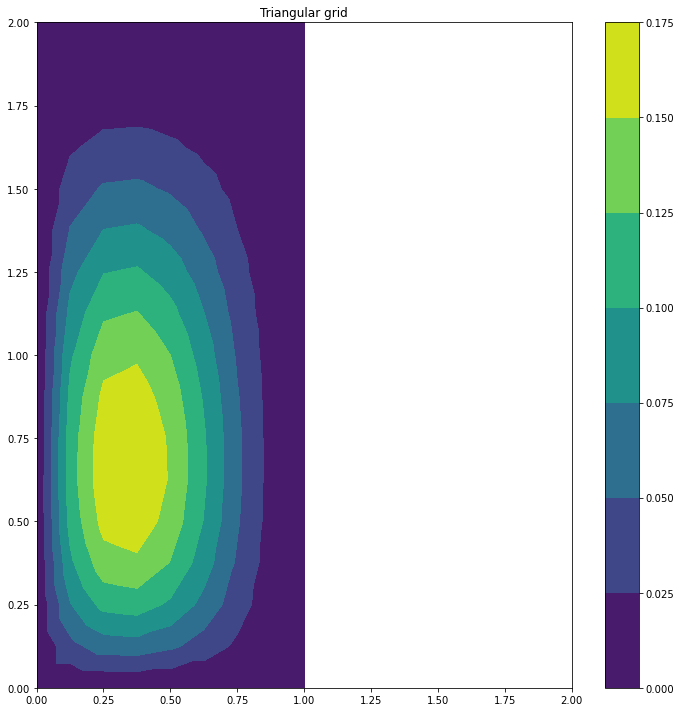

In [12]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u_approx.ravel()

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)

ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

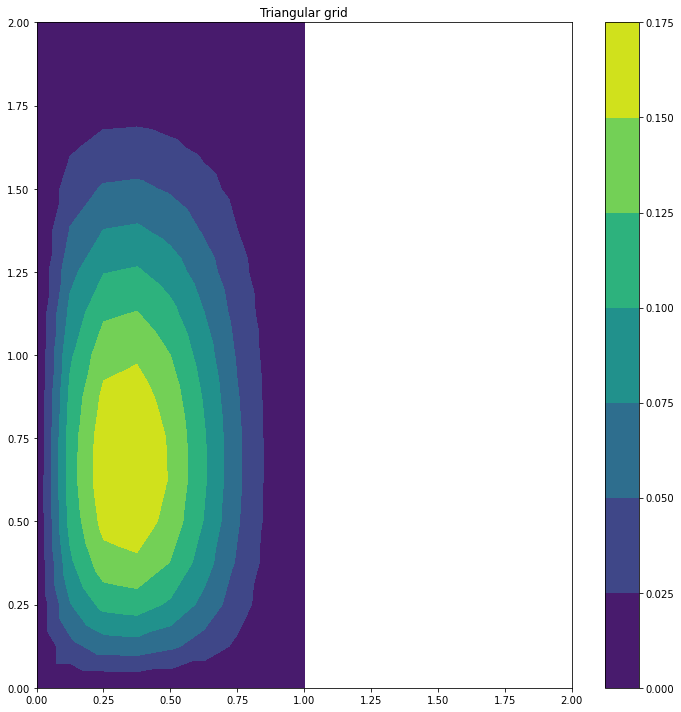

In [13]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

In [14]:
def show_success(index):
    point_index = int(len(points) * index)

    print("Exact solution: \t", ex[point_index])
    print("Approximate solution: \t", u_approx[point_index])
    print("Error: \t\t\t", np.abs(ex[point_index] - u_approx[point_index][0]))
    print('{:.2e}'.format(np.abs(ex[point_index] - u_approx[point_index][0])))
    print()


In [15]:
for coef in [0, 0.1, 0.57, 0.81]:
    show_success(coef)

Exact solution: 	 0.0
Approximate solution: 	 [-2.59988116e-21]
Error: 			 2.5998811585648924e-21
2.60e-21

Exact solution: 	 0.0
Approximate solution: 	 [1.40634456e-22]
Error: 			 1.4063445624064008e-22
1.41e-22

Exact solution: 	 0.067291259765625
Approximate solution: 	 [0.06724042]
Error: 			 5.0842877463430636e-05
5.08e-05

Exact solution: 	 0.015380859375
Approximate solution: 	 [0.01535829]
Error: 			 2.2568973298903866e-05
2.26e-05



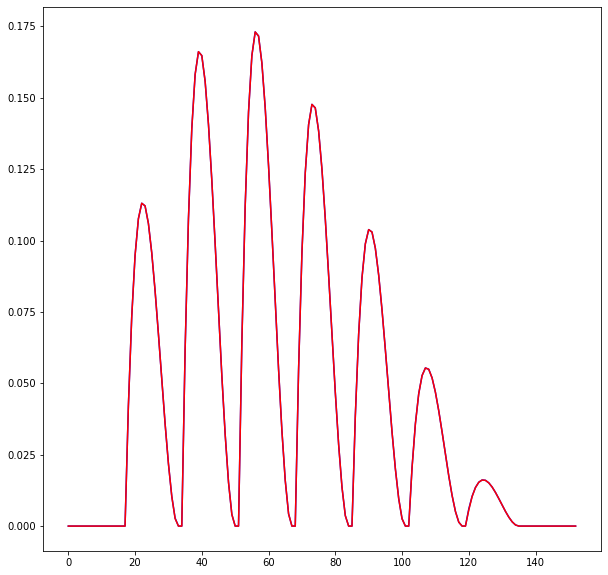

In [16]:
mesh = range(len(u_approx))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(mesh, ex, 'blue')
ax.plot(mesh, u_approx, 'red')


In [17]:
u_approx = u_approx.ravel()

In [18]:
def segment_volume(h1, h2, h3, s=triangle_area):
    return s*(h1+h2+h3)/3

In [19]:
def dbl_integ(u, triangles):
    '''
    :param u: array
    '''
    integral = 0
    for (p1, p2, p3) in triangles:
        
        integral += segment_volume(u[p1], u[p2], u[p3])
        
    return integral

In [20]:
def norm_L2(u, triangles):
    '''
    :param u: array
    '''
    return dbl_integ(u**2, triangles)

In [21]:
err_abs_L2 = pow(norm_L2(u(x, y)-u_approx, triangles), 1/2)
err_abs_L2

6.263063820486674e-05

In [22]:
err_rel_L2 = pow(err_abs_L2/norm_L2(u(x, y), triangles), 1/2) * 100
err_rel_L2

7.348026467617701

Wasserstein distance:
$$\|u(x)\|_{W_{2}^{(1)}}^{2}=\int_{\Omega}\left(u(x)^{2}+\frac{\partial u(x)^{2}}{\partial x_{1}}+\frac{\partial u(x)^{2}}{\partial x_{2}}\right) d \Omega$$

$$
\varphi_{i}^{(e)}\left(x_{1}^{(i)}, x_{2}^{(i)}\right)=\frac{1}{\delta}\left(a_{i}+b_{i} x_{1}+c_{i} x_{2}\right)
$$

$$u_{h}=u_{i}^{h} \varphi_{i}^{(e)}\left(x_{1}, x_{2}\right)+u_{j}^{h} \varphi_{j}^{(e)}\left(x_{1}, x_{2}\right)+u_{m}^{h} \varphi_{m}^{(e)}\left(x_{1}, x_{2}\right)$$

$$\frac{\partial u(x)}{\partial x_{1}}=
  \frac{u_{i}^{h}}{\delta}b_i
+\frac{u_{j}^{h}}{\delta}b_j
+\frac{u_{m}^{h}}{\delta}b_m$$

$$\frac{\partial u_h(x)}{\partial x_{2}}=
  \frac{u_{i}^{h}}{\delta}c_i
+\frac{u_{j}^{h}}{\delta}c_j
+\frac{u_{m}^{h}}{\delta}c_m$$

In [23]:
def norm_W2(u, du_dx1, du_dx2, triangles):
    '''
    :param u: array
    '''
    u_ = u**2 + du_dx1**2 + du_dx2**2
    
    return dbl_integ(u_, triangles)

In [24]:
du_approx_dx1 = np.zeros(n)
for i, (p1, p2, p3) in enumerate(triangles):
        
        du_approx_dx1[i] = (u_approx[p1]*b[i][0] +  u_approx[p2]*b[i][1] + u_approx[p3]*b[i][2]) / 2*s

In [25]:
du_approx_dx2 = np.zeros(n)
for i, (p1, p2, p3) in enumerate(triangles):
        
        du_approx_dx1[i] = (u_approx[p1]*c[i][0] +  u_approx[p2]*c[i][1] + u_approx[p3]*c[i][2]) / 2*s

In [26]:
norm_W2(u(x, y) - u_approx, du_dx1(x, y) - du_approx_dx1, du_dx2(x, y) - du_approx_dx2)

ValueError: operands could not be broadcast together with shapes (153,) (256,) 

In [27]:
du_dx1(x, y) - du_approx_dx1

ValueError: operands could not be broadcast together with shapes (153,) (256,) 

In [28]:
len(triangles)

256

In [ ]:
len((u_approx[p1]*b[i][0] +  u_approx[p2]*b[i][1] + u_approx[p3]*b[i][2]) / 2*s)

In [32]:
len(set(u_approx))

153

In [35]:
len(set(du_dx1(x, y)))

121